# Machine Learning - Homework 2

This homework has been done on Google Colaboratory, which is actually mandatory to run the code below.

## Load data

Zip the dataset folder as `dataset.zip` and place it in the root of Google Drive, or set the `dataset_dir` variable with the right path.

In [103]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [104]:
!pip install split-folders

import numpy as np
import tensorflow as tf
import splitfolders
import keras
import os

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import image, pyplot as plt
from sklearn.model_selection import train_test_split

In [105]:
dataset_dir = "/content/gdrive/MyDrive/dataset.zip"

assert os.path.isfile(dataset_dir), "dataset zip file not found in " + dataset_dir

!cp {dataset_dir} "/content/"
!unzip -uq "/content/dataset.zip"

splitfolders.ratio("/content/dataset/", output="/content/new_dataset/", seed=42, ratio=(.7, .3), group_prefix=None) # default values

train_dir = "/content/new_dataset/train/"
val_dir = "/content/new_dataset/val/"

Copying files: 8221 files [00:01, 5527.12 files/s]


In [107]:
batch_size = 32
img_height = img_width = 250
color_mode = "rgb"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

class_names = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %class_names)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(val_generator.n,val_generator.num_classes))

Found 5750 images belonging to 8 classes.
Found 2471 images belonging to 8 classes.
Image input (250, 250, 3)
Classes: ['Breadsticks', 'Cereals_box', 'Cocoa_drink_bottle', 'Nitrile_Gloves', 'Pears', 'accent_plate', 'paper_bag', 'plastic_fork']
Loaded 5750 training samples from 8 classes.
Loaded 2471 test samples from 8 classes.


## Show 10 images from the dataset

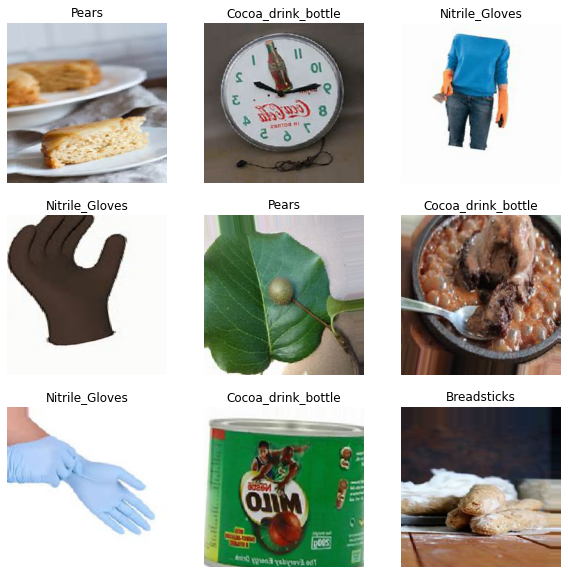

In [108]:
plt.figure(figsize=(10, 10))

images, labels = train_generator.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(class_names[labels[i].argmax()])
  plt.axis("off")

## Create the model

In [116]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    Conv2D(16, 3, input_shape=input_shape, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 64)      

### Train

In [112]:
steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size + 1
epochs = 10

history = model.fit(train_generator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps)

Epoch 1/10
179/179 [==============================] - 92s 513ms/step - loss: 1.7225 - accuracy: 0.4253 - val_loss: 1.3396 - val_accuracy: 0.5245
Epoch 2/10
179/179 [==============================] - 92s 513ms/step - loss: 1.3019 - accuracy: 0.5581 - val_loss: 1.2564 - val_accuracy: 0.5621
Epoch 3/10
179/179 [==============================] - 92s 515ms/step - loss: 1.1972 - accuracy: 0.5964 - val_loss: 1.2362 - val_accuracy: 0.5670
Epoch 4/10
179/179 [==============================] - 92s 514ms/step - loss: 1.1237 - accuracy: 0.6205 - val_loss: 1.1043 - val_accuracy: 0.6370
Epoch 5/10
179/179 [==============================] - 92s 512ms/step - loss: 1.0638 - accuracy: 0.6389 - val_loss: 1.0229 - val_accuracy: 0.6580
Epoch 6/10
179/179 [==============================] - 91s 508ms/step - loss: 1.0310 - accuracy: 0.6532 - val_loss: 1.1050 - val_accuracy: 0.6333
Epoch 7/10
179/179 [==============================] - 91s 506ms/step - loss: 0.9877 - accuracy: 0.6579 - val_loss: 1.0134 - val_ac

## Evaluate the model

In [114]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps = val_generator.n // val_generator.batch_size + 1

preds = model.predict(val_generator, verbose=1, steps=val_steps)

Y_pred = np.argmax(preds, axis=1)
Y_val = val_generator.classes  # shuffle=False in val_generator

print(classification_report(Y_val, Y_pred, labels=None, target_names=class_names, digits=3))

78/78 [==============================] - 6s 71ms/step
                    precision    recall  f1-score   support

       Breadsticks      0.868     0.569     0.687       313
       Cereals_box      0.664     0.837     0.740       344
Cocoa_drink_bottle      0.621     0.470     0.535       296
    Nitrile_Gloves      0.792     0.741     0.766       309
             Pears      0.654     0.869     0.746       306
      accent_plate      0.714     0.839     0.771       322
         paper_bag      0.706     0.521     0.600       355
      plastic_fork      0.577     0.695     0.631       226

          accuracy                          0.693      2471
         macro avg      0.699     0.693     0.684      2471
      weighted avg      0.704     0.693     0.687      2471



### Plot results

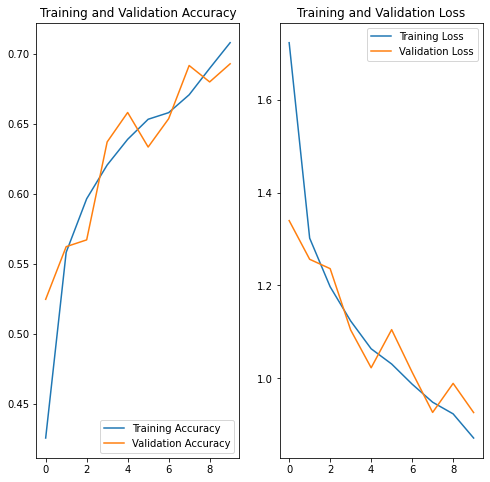

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()